In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


2024-12-31 14:33:15.945046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 14:33:15.945137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 14:33:15.992910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 14:33:16.071460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os

# Add the scripts folder to the system path
scripts_path = os.path.abspath(os.path.join('..', 'scripts/python'))
sys.path.append(scripts_path)


In [40]:
# data_processing.ipynb

# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

# Import functions from utils.py
from utils import (
    AR,
    check_percentage_tashkeel,
    Clean_data,
    separate_token_with_diacritics,
    factor_shadda_tanwin,
    string_with_tashkeel_vectorizer,
    string_with_tashkeel_vectorizer_per_batch,
    calculate_meter_accuracy,
    get_verse_length_features
)

# Configure visualization settings
%matplotlib inline
sns.set(style="whitegrid")


In [17]:
# Define paths
original_csv = '../data/raw/apcd/apcd_full.csv'
diacritized_csv = '../data/raw/apcd/apcd_full_diacritized.csv'
processed_output_dir = '../data/processed'
os.makedirs(processed_output_dir, exist_ok=True)
# Define the meter pattern for الطويل
taweel_pattern = "―∪∪――∪∪―"

#Load the datasets
print("Loading original dataset...")
original_df = pd.read_csv(original_csv, encoding='utf-8-sig')
print(f"Original dataset loaded with {len(original_df)} records.")

print("Loading auto-diacritized dataset...")
diacritized_df = pd.read_csv(diacritized_csv, encoding='utf-8-sig')
print(f"Auto-diacritized dataset loaded with {len(diacritized_df)} records.")



Loading original dataset...
Original dataset loaded with 1831770 records.
Loading auto-diacritized dataset...
Auto-diacritized dataset loaded with 1831770 records.


In [18]:
# Ensure alignment between datasets
if len(original_df) != len(diacritized_df):
    raise ValueError("Original and diacritized datasets have different record counts!")


In [20]:
# Filter for "طويل بحر"
print("Filtering for 'طويل بحر'...")
original_df = original_df[original_df['البحر'] == 'الطويل']
diacritized_df = diacritized_df[diacritized_df['البحر'] == 'الطويل']
print(f"Filtered Original dataset size: {len(original_df)}")
print(f"Filtered Diacritized dataset size: {len(diacritized_df)}")

Filtering for 'طويل بحر'...
Filtered Original dataset size: 405378
Filtered Diacritized dataset size: 405378


In [21]:
import unicodedata

def merge_albayt(original, diacritized):
    """
    Compare original and diacritized Albayt values letter by letter.
    - If the auto-diacritized value has a diacritic but the original doesn't, keep the auto-diacritized.
    - If both the original and diacritized have diacritics for the same character, prioritize the original.

    Args:
        original (str): Original Albayt value.
        diacritized (str): Auto-diacritized Albayt value.

    Returns:
        str: Merged Albayt value.
    """
    merged = []
    for orig_char, dia_char in zip(original, diacritized):
        # Extract base characters and diacritics
        orig_base = unicodedata.normalize('NFD', orig_char)
        dia_base = unicodedata.normalize('NFD', dia_char)
        
        orig_base_char = orig_base[0]
        dia_base_char = dia_base[0]

        # Case 1: If base characters differ, prioritize the original character
        if orig_base_char != dia_base_char:
            merged.append(orig_char)
        else:
            # Base characters match, compare diacritics
            orig_diacritics = ''.join(c for c in orig_base[1:] if unicodedata.category(c) == 'Mn')
            dia_diacritics = ''.join(c for c in dia_base[1:] if unicodedata.category(c) == 'Mn')
            
            # Case 2: If original has diacritics, keep the original character
            if orig_diacritics:
                merged.append(orig_char)
            # Case 3: Otherwise, use the diacritized version
            elif dia_diacritics:
                merged.append(dia_char)
            # Case 4: If neither has diacritics, keep the original character
            else:
                merged.append(orig_char)
    
    # Handle cases where one string is longer than the other
    if len(original) > len(diacritized):
        merged.extend(original[len(diacritized):])
    elif len(diacritized) > len(original):
        merged.extend(diacritized[len(original):])
    
    return ''.join(merged)

    
# Function to safely compare and remove problematic rows
def safe_merge_albayt(row):
    try:
        # Perform the merge
        return merge_albayt(row['البيت'], diacritized_df.loc[row.name, 'البيت'])
    except Exception as e:
        print(f"Deleting row {row.name} due to error: {e}")
        # Drop the row from both dataframes
        original_df.drop(index=row.name, inplace=True)
        diacritized_df.drop(index=row.name, inplace=True)
        return None  # This value won't be used as the row is being deleted

# Apply the function
print("Merging Albayt column and deleting problematic rows...")
original_df['final_albayt'] = original_df.apply(safe_merge_albayt, axis=1)
print("Merged Albayt column created.")


Merging Albayt column and deleting problematic rows...
Deleting row 515152 due to error: 'float' object is not iterable
Deleting row 653704 due to error: 'float' object is not iterable
Deleting row 1507784 due to error: 'float' object is not iterable
Merged Albayt column created.


In [24]:
# Preview raw data
original_df.head()

,العصر,الشاعر,الديوان,القافية,البحر,الشطر الايسر,الشطر الايمن,البيت,final_albayt
0,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...,خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا وَأَن...
1,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...,فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ وَلا سُ...
2,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...,وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً وَتَ...
3,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...,لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ تُؤامِرُ...
4,قبل الإسلام,عمرو بنِ قُمَيئَة,الديوان الرئيسي,د,الطويل,وَأَفرَعَ في لَومي مِراراً وَأَصعَدا,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...,وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ وَأَفر...


In [32]:
raw_df = original_df.copy()


In [33]:
# Apply diacritization filtering
tashkeel_threshold = 0.7  # Adjust as needed
print(f"Applying diacritization filtering with threshold {tashkeel_threshold}...")
raw_df['passes_diacritization'] = raw_df['final_albayt'].apply(lambda x: check_percentage_tashkeel(x, threshold=tashkeel_threshold))
filtered_df = raw_df[raw_df['passes_diacritization']].copy()
print(f"Filtered dataset size: {len(filtered_df)}")

Applying diacritization filtering with threshold 0.7...
Filtered dataset size: 103441


In [35]:
import pandas as pd

# Print full content of the first 5 rows for the column "البيت"
pd.set_option('display.max_colwidth', None)
print(filtered_df["البيت"].head())


0      خَليلَيَّ لا تَستَعجِلا أَن تَزَوَّدا    وَأَن تَجمَعا شَملي وَتَنتَظِرا غَدا
1       فَما لَبَثٌ يَوماً بِسابِقٍ مَغنَمٍ    وَلا سُرعَتي يَوماً بِسابِقَةِ الرَدى
2    وَإِن تُنظِراني اليَومَ أَقضِ لُبانَةً    وَتَستَوجِبا مَنّاً عَلَيَّ وَتُحمَدا
3          لَعَمرُكَ ما نَفسٌ بِجِدٍ رَشيدَةٍ    تُؤامِرُني سِرّاً لِأَصرِمَ مَرثَدا
4       وَإِن ظَهَرَت مِنهُ قَوارِصُ جَمَّةٌ    وَأَفرَعَ في لَومي مِراراً وَأَصعَدا
Name: البيت, dtype: object


In [38]:
# Calculate meter accuracy
print("Calculating meter accuracy for Taweel...")
filtered_df['meter_accuracy'] = filtered_df['البيت'].apply(
    lambda verse: calculate_meter_accuracy(verse, taweel_pattern)
)
print("Meter accuracy calculation complete.")

Calculating meter accuracy for Taweel...
Meter accuracy calculation complete.


In [41]:
# Add verse length features
print("Calculating verse length features...")
filtered_df = get_verse_length_features(filtered_df)
print("Verse length features added.")

Calculating verse length features...
Verse length features added.


In [42]:
# Select and rename relevant columns
print("Selecting and renaming columns...")
processed_df = filtered_df[['البيت', 'البحر', 'العصر', 'الشاعر', 'القافية', 'meter_accuracy', 'verse_length', 'avg_shatr_length']].rename(columns={
    'البيت': 'text',
    'البحر': 'meter',
    'العصر': 'era',
    'الشاعر': 'poet',
    'القافية': 'rhyme'
})
print("Columns selected and renamed.")

Selecting and renaming columns...
Columns selected and renamed.


In [43]:
# Clean the text data
max_bayt_len = 1000
print("Cleaning the text data...")
processed_df = Clean_data(processed_df, max_bayt_len=max_bayt_len, verse_column_name='text')
print("Text data cleaned.")

Cleaning the text data...
Text data cleaned.


In [44]:
# Preview processed data
processed_df.head()


,text,meter,era,poet,rhyme,meter_accuracy,verse_length,avg_shatr_length
0,خَليلَيْيَ لا تَستَعجِلا ءَن تَزَوْوَدا وَءَن تَجمَعا شَملي وَتَنتَظِرا غَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,39.02,73,36.5
1,فَما لَبَثُنْ يَومنْ بِسابِقِنْ مَغنَمِنْ وَلا سُرعَتي يَومنْ بِسابِقَةِ الرَدى,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,38.10,72,36.0
2,وَءِن تُنظِراني اليَومَ ءَقضِ لُبانَتَنْ وَتَستَوجِبا مَنْننْ عَلَيْيَ وَتُحمَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,37.21,75,37.5
3,لَعَمرُكَ ما نَفسُنْ بِجِدِنْ رَشيدَتِنْ تُءامِرُني سِرْرنْ لِءَصرِمَ مَرثَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,40.00,69,34.5
4,وَءِن ظَهَرَت مِنهُ قَوارِصُ جَمْمَتُنْ وَءَفرَعَ في لَومي مِرارنْ وَءَصعَدا,الطويل,قبل الإسلام,عمرو بنِ قُمَيئَة,د,39.02,72,36.0


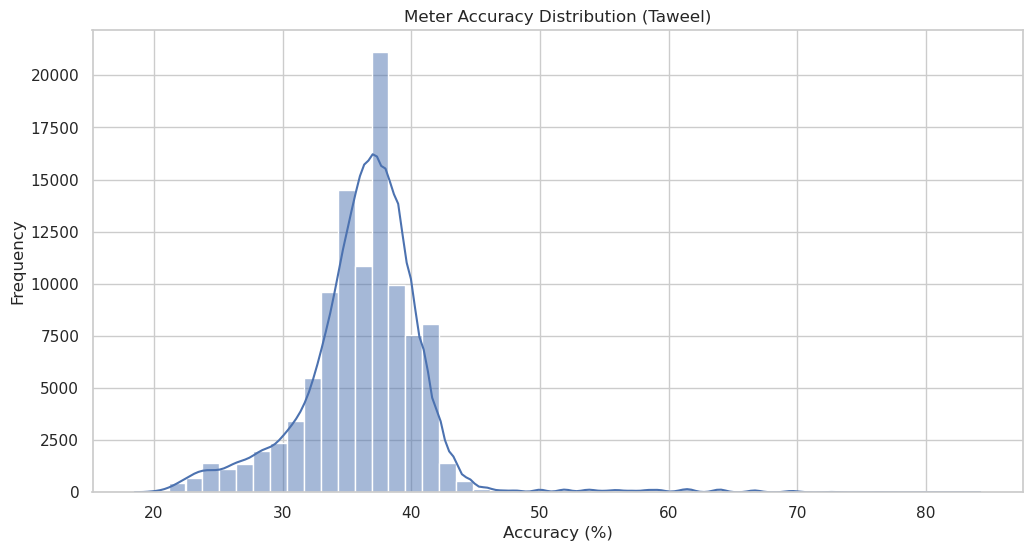

In [45]:
# Visualizations
# Meter accuracy distribution
plt.figure(figsize=(12, 6))
sns.histplot(processed_df['meter_accuracy'], bins=50, kde=True)
plt.title('Meter Accuracy Distribution (Taweel)')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')
plt.show()

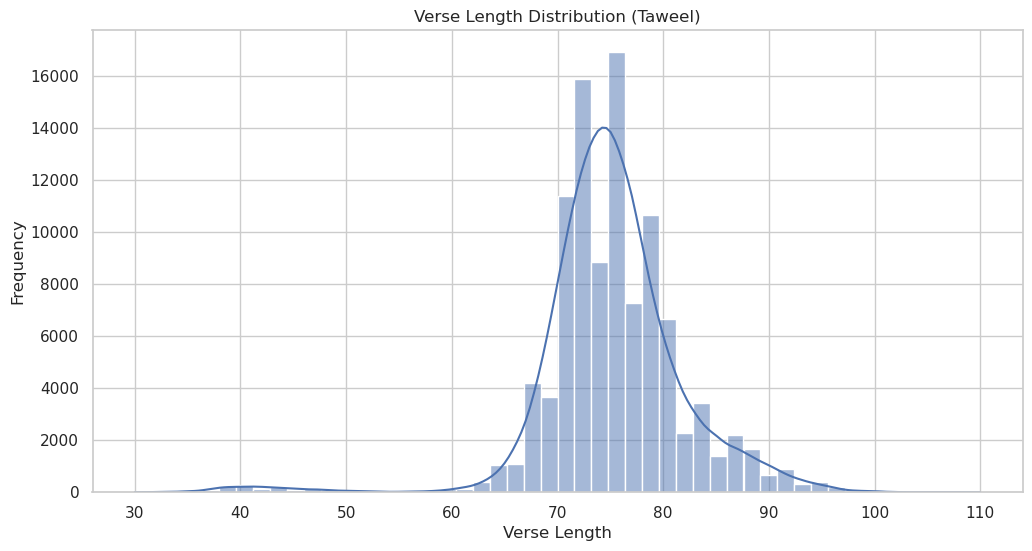

In [46]:
# Verse length distribution
plt.figure(figsize=(12, 6))
sns.histplot(processed_df['verse_length'], bins=50, kde=True)
plt.title('Verse Length Distribution (Taweel)')
plt.xlabel('Verse Length')
plt.ylabel('Frequency')
plt.show()

In [47]:
# Save processed data
output_path = os.path.join(processed_output_dir, 'processed_taweel_data.csv')
print("Saving processed data...")
processed_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Processed data saved to {output_path}")

Saving processed data...
Processed data saved to ../data/processed/processed_taweel_data.csv
